In [2]:
# importing the required libraries
import numpy as np 
import pandas as pd
import os
import seaborn as sns
import isbnlib
from newspaper import Article
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tqdm import tqdm
from progressbar import ProgressBar
import re
from scipy.cluster.vq import kmeans, vq
from pylab import plot, show
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import goodreads_api_client as gr
from sklearn.cluster import KMeans
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Reading the dataset
df=pd.read_csv("books.csv",error_bad_lines = False)
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,439785960,9.780000e+12,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,439358078,9.780000e+12,eng,870,2153167,29221,09-01-2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,439554896,9.780000e+12,eng,352,6333,244,11-01-2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9.780000e+12,eng,435,2339585,36325,05-01-2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,439682584,9.780000e+12,eng,2690,41428,164,9/13/2004,Scholastic


In [4]:
#Checking the data frame
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,439785960,9.780000e+12,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,439358078,9.780000e+12,eng,870,2153167,29221,09-01-2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,439554896,9.780000e+12,eng,352,6333,244,11-01-2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9.780000e+12,eng,435,2339585,36325,05-01-2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,439682584,9.780000e+12,eng,2690,41428,164,9/13/2004,Scholastic


In [5]:
#Checking the dimensions of dataframe
df.shape

(11127, 12)

In [6]:
# setting bookID as index and dropping the 'bookID' column from dataset
df.set_index('bookID',inplace=True,drop=True)

In [7]:
#Checking null values and data types in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11127 entries, 1 to 45641
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               11127 non-null  object 
 1   authors             11127 non-null  object 
 2   average_rating      11127 non-null  float64
 3   isbn                11127 non-null  object 
 4   isbn13              11127 non-null  float64
 5   language_code       11127 non-null  object 
 6     num_pages         11127 non-null  int64  
 7   ratings_count       11127 non-null  int64  
 8   text_reviews_count  11127 non-null  int64  
 9   publication_date    11127 non-null  object 
 10  publisher           11127 non-null  object 
dtypes: float64(2), int64(3), object(6)
memory usage: 1.0+ MB


In [8]:
# Replacing the author name 'J.K. Rowling-Mary GrandPré' with 'J.K. Rowling' since it has special character
df.replace(to_replace='J.K. Rowling-Mary GrandPré', value = 'J.K. Rowling', inplace=True)

# Exploratory Data Analysis

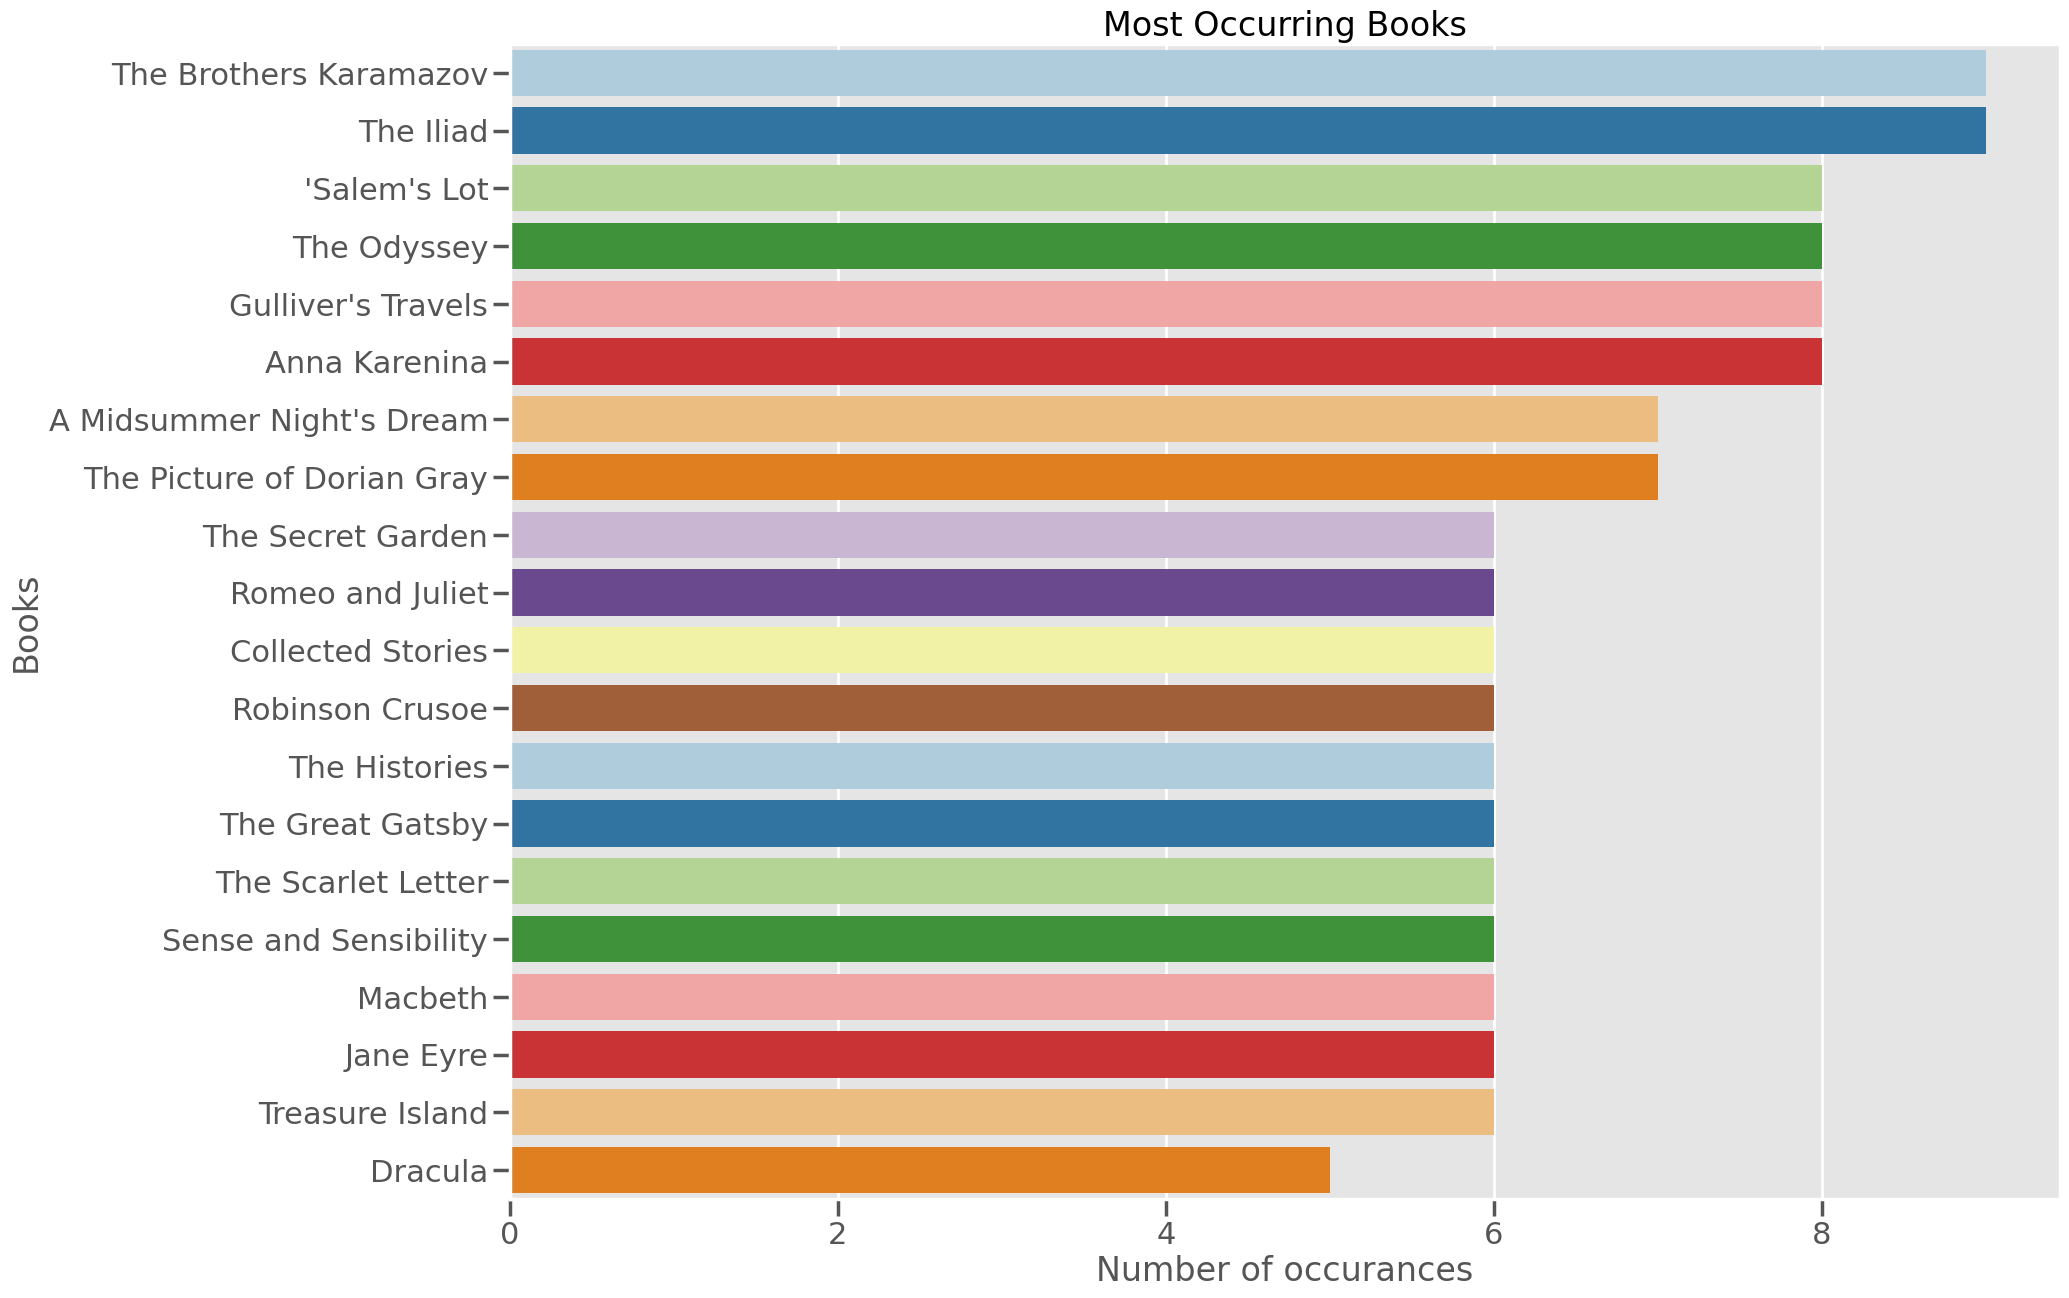

In [9]:
#Taking the first 20 which are most occuring in the dataset
sns.set_context('poster')
plt.figure(figsize=(20,15))
books = df['title'].value_counts()[:20]
sns.barplot(x = books, y = books.index, palette='Paired')
plt.title("Most Occurring Books")
plt.xlabel("Number of occurances")
plt.ylabel("Books")
plt.show()

We can see that 'The Brothers Karamazov' and 'The lliad' have the most number of occurrances with the same name in the data.
These books have come up in this dataset over and over again, with various publication editions. 

<AxesSubplot:xlabel='ratings_count', ylabel='title'>

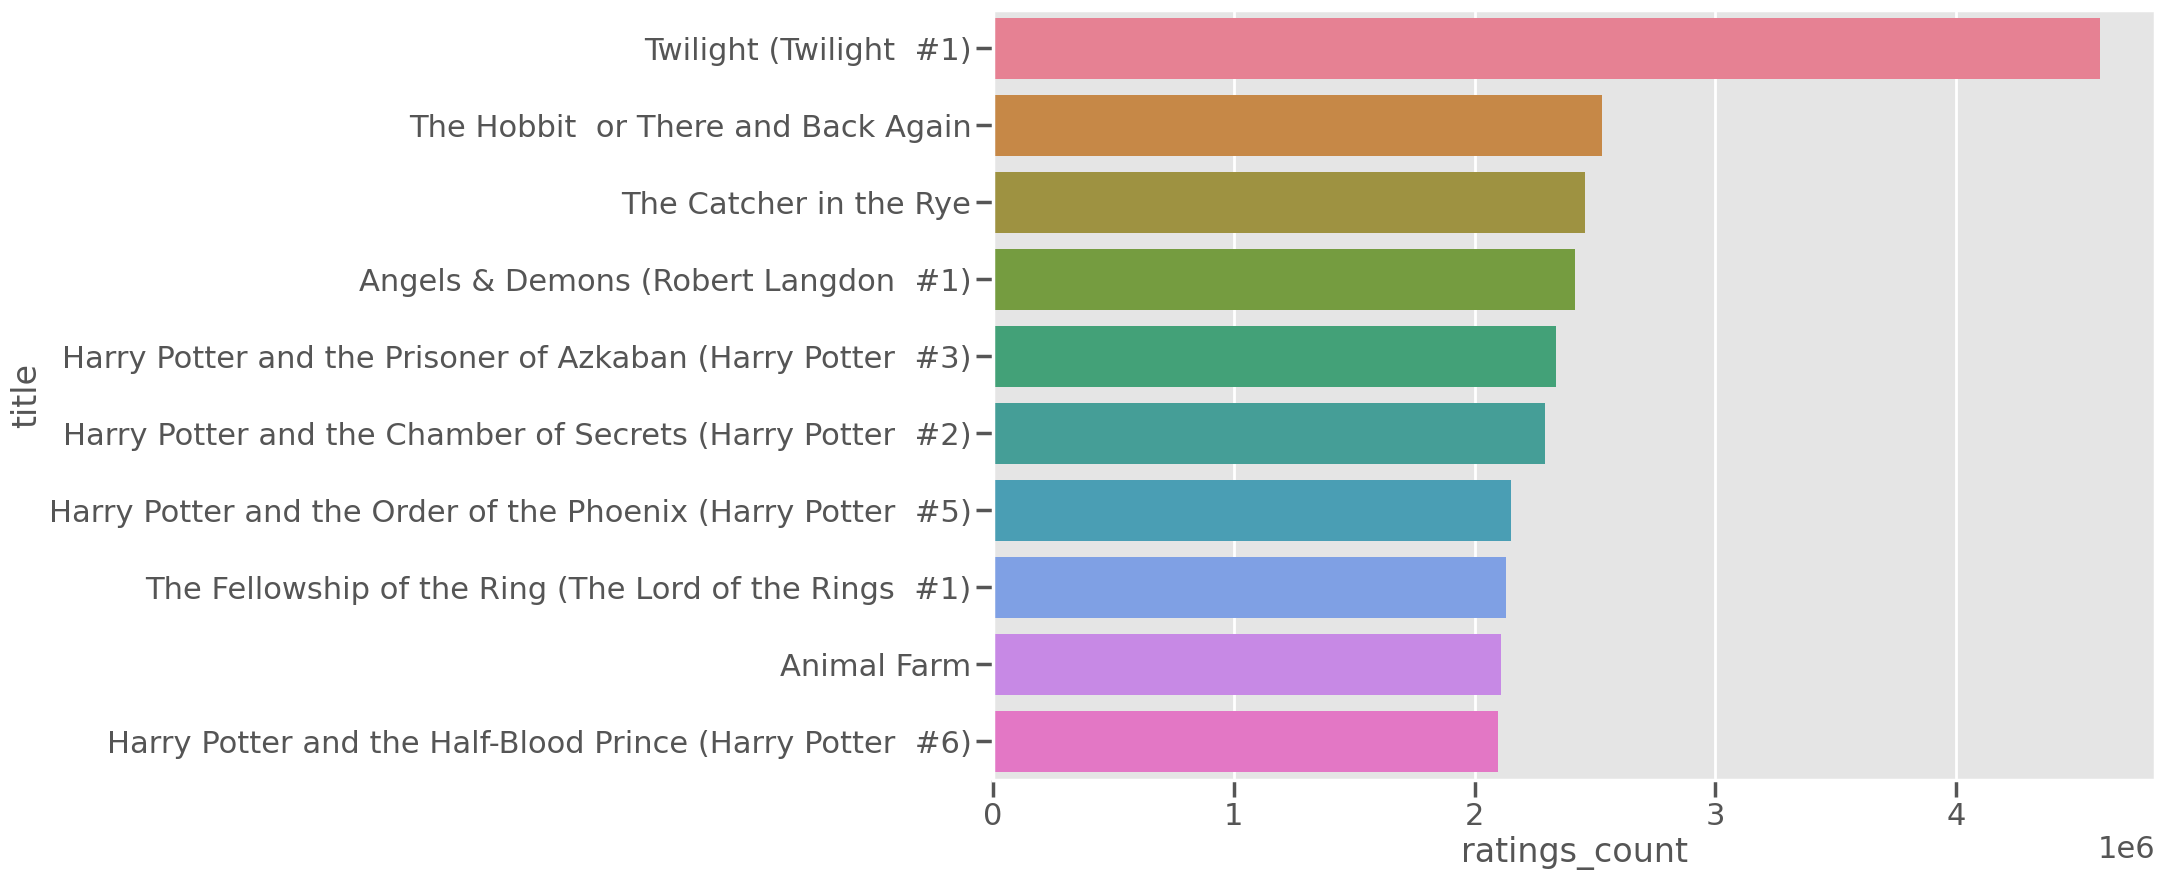

In [10]:
# Finding the top rated books
most_rated = df.sort_values('ratings_count', ascending = False).head(10).set_index('title')
plt.figure(figsize=(15,10))
sns.barplot(most_rated['ratings_count'], most_rated.index, palette='husl')

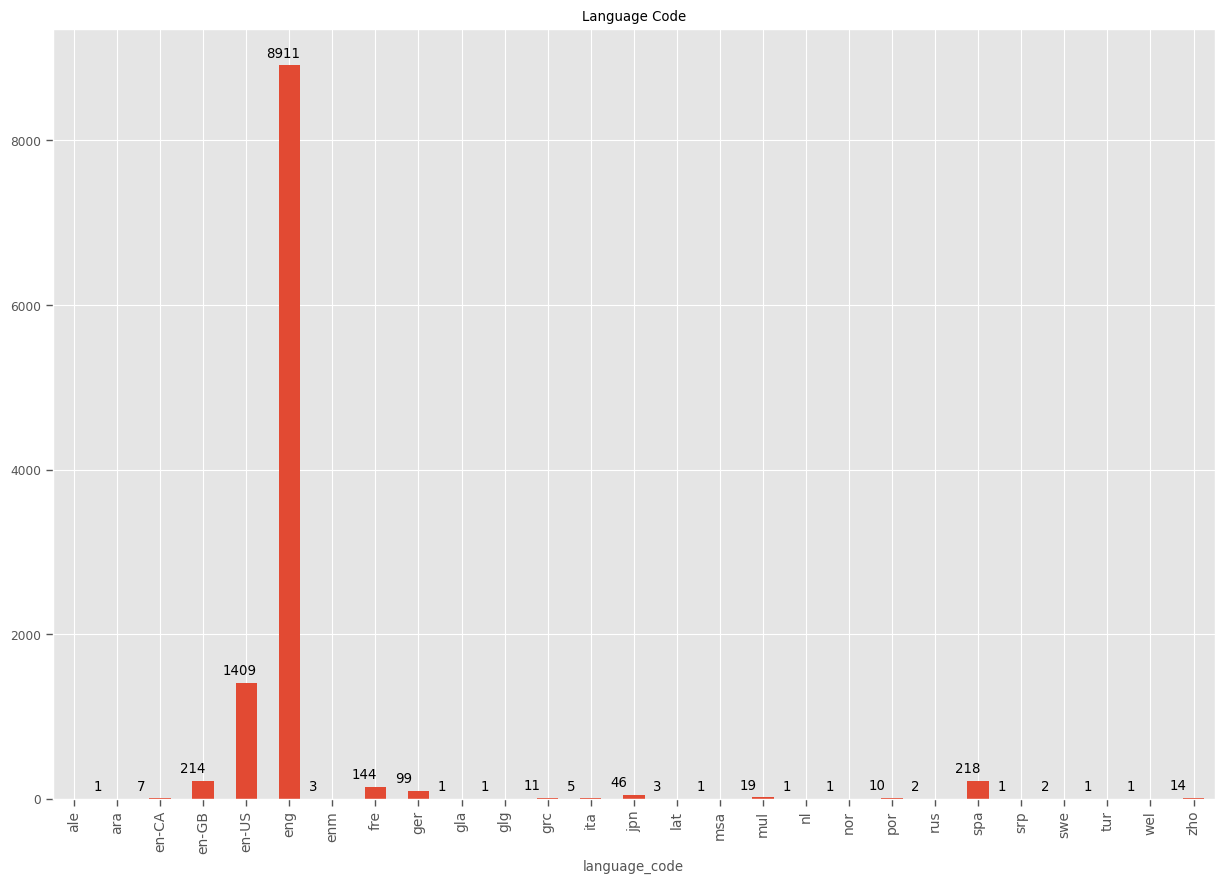

In [11]:
# Finding the distribution of books in different languages
sns.set_context('paper')
plt.figure(figsize=(15,10))
ax = df.groupby('language_code')['title'].count().plot.bar()
plt.title('Language Code')
plt.xticks(fontsize = 10)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()-0.3, p.get_height()+100))


In [12]:
df.groupby('language_code')['title'].count()

language_code
ale         1
ara         1
en-CA       7
en-GB     214
en-US    1409
eng      8911
enm         3
fre       144
ger        99
gla         1
glg         1
grc        11
ita         5
jpn        46
lat         3
msa         1
mul        19
nl          1
nor         1
por        10
rus         2
spa       218
srp         1
swe         2
tur         1
wel         1
zho        14
Name: title, dtype: int64

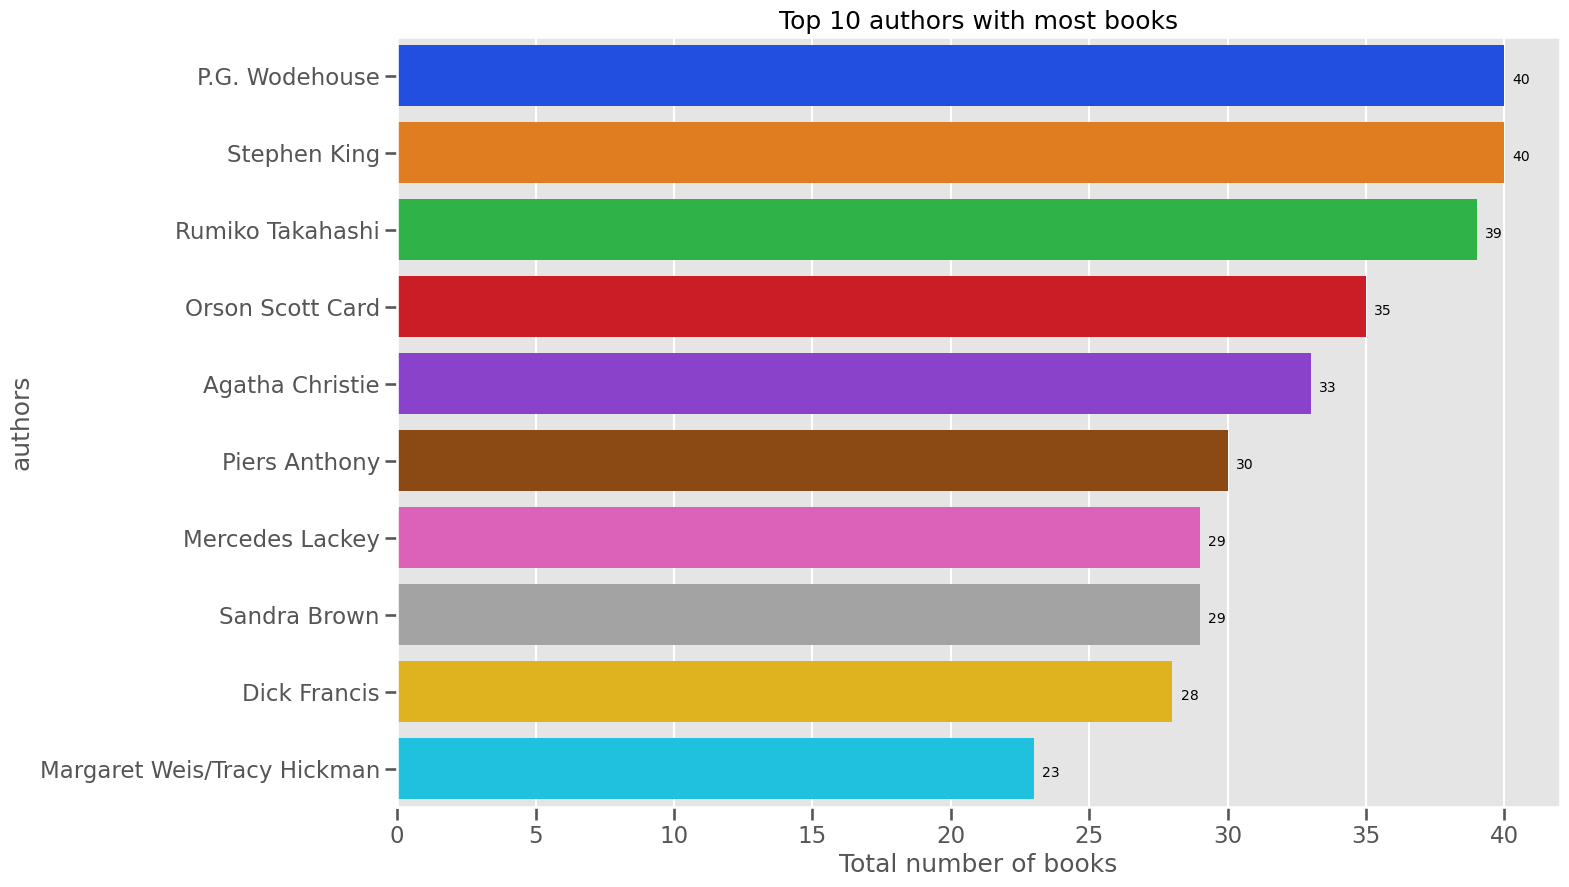

In [13]:
# Finding top 10 authors with most books
sns.set_context('talk')
most_books = df.groupby('authors')['title'].count().reset_index().sort_values('title', ascending=False).head(10).set_index('authors')
plt.figure(figsize=(15,10))
ax = sns.barplot(most_books['title'], most_books.index, palette='bright')
ax.set_title("Top 10 authors with most books")
ax.set_xlabel("Total number of books")
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+0.5, str(round(i.get_width())), fontsize = 10, color = 'k')

In [14]:
# Select books written by a specific author
author = 'P.G. Wodehouse'
books_by_author = df[df['authors'] == author]
# Sort the books by average rating
top_rated_books = books_by_author.sort_values('average_rating', ascending=False)
# Print the top 10 rated books
print(top_rated_books[['title', 'average_rating']].head(10))

                                             title  average_rating
bookID                                                            
16374                   The Most of P.G. Wodehouse            4.48
16379        Life With Jeeves (Jeeves  #6  2  & 4)            4.39
18017                            Life at Blandings            4.35
18081              Joy in the Morning (Jeeves  #8)            4.34
18064                    The World of Mr. Mulliner            4.32
18074   Jeeves and The Feudal Spirit (Jeeves  #11)            4.32
18035                Right Ho  Jeeves (Jeeves  #6)            4.32
12550        Stiff Upper Lip  Jeeves (Jeeves  #13)            4.29
16387                Carry On  Jeeves (Jeeves  #3)            4.27
16390               The Mating Season (Jeeves  #9)            4.26


In [15]:
# Select books written by a specific author
author = 'Stephen King'
books_by_author = df[df['authors'] == author]
# Sort the books by average rating
top_rated_books = books_by_author.sort_values('average_rating', ascending=False)
# Print the top 10 rated books
print(top_rated_books[['title', 'average_rating']].head(10))

                                                title  average_rating
bookID                                                               
5417              Carrie / 'Salem's Lot / The Shining            4.54
11566                                  The Green Mile            4.44
39662                               Different Seasons            4.35
33348                               Different Seasons            4.35
11584                            On Writing: A Memoir            4.33
22549              The Dark Tower (The Dark Tower #7)            4.28
5094    The Drawing of the Three (The Dark Tower  #2)            4.23
12684                                     The Shining            4.22
12682                                     The Shining            4.22
11588                                     The Shining            4.22


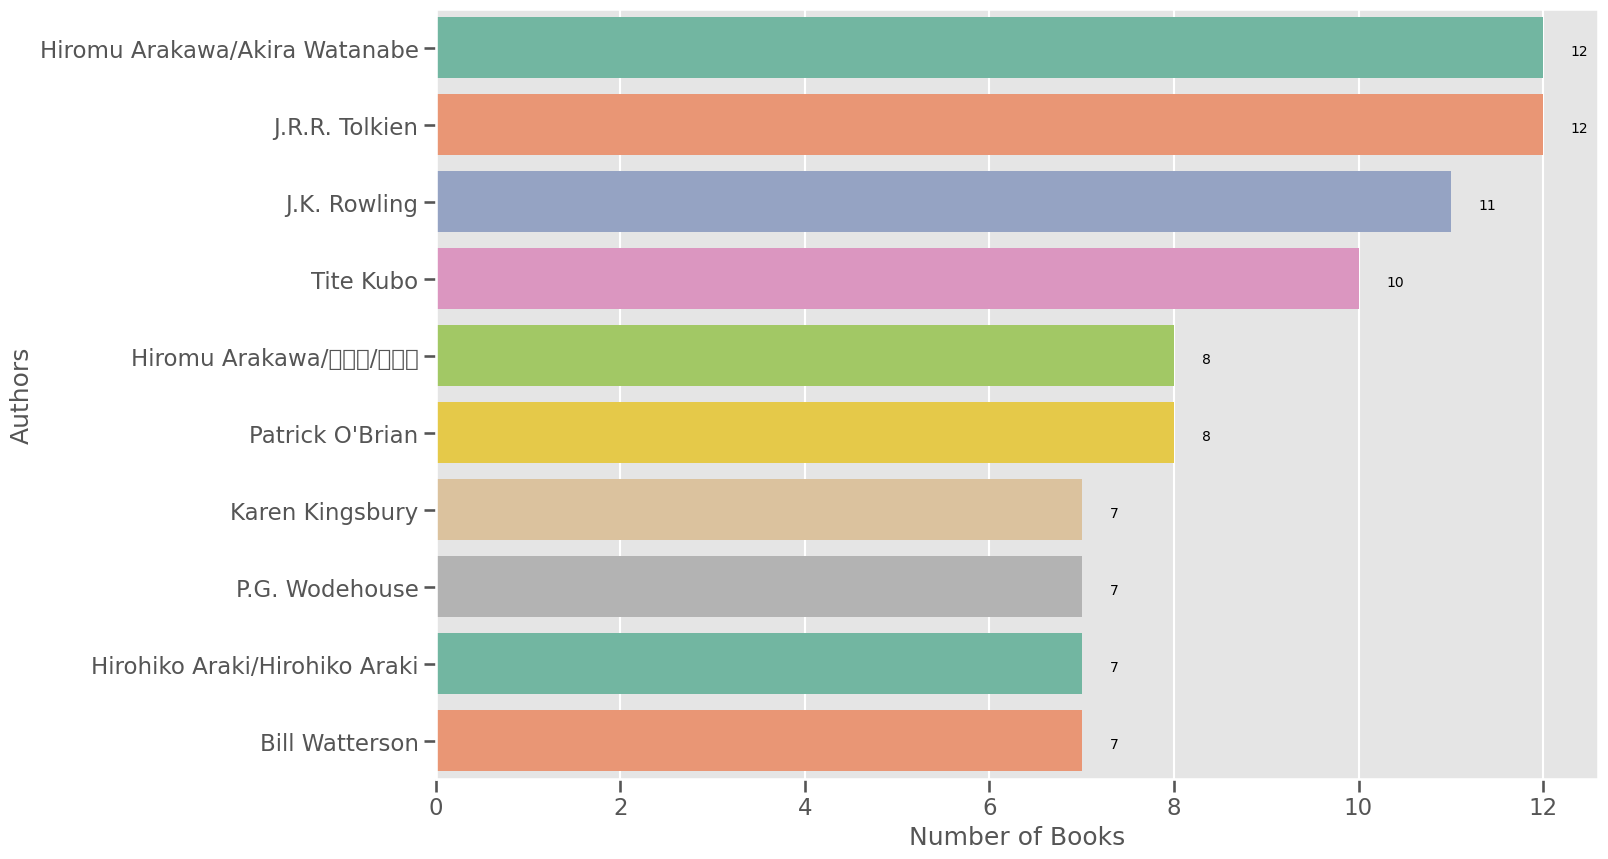

In [16]:
# Finding the top rated authors
high_rated_author = df[df['average_rating']>=4.3]
high_rated_author = high_rated_author.groupby('authors')['title'].count().reset_index().sort_values('title', ascending = False).head(10).set_index('authors')
plt.figure(figsize=(15,10))
ax = sns.barplot(high_rated_author['title'], high_rated_author.index, palette='Set2')
ax.set_xlabel("Number of Books")
ax.set_ylabel("Authors")
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+0.5, str(round(i.get_width())), fontsize = 10, color = 'k')

In [17]:
# Select books written by a specific author
author = 'Hiromu Arakawa/Akira Watanabe'
books_by_author = df[df['authors'] == author]

# Sort the books by average rating
top_rated_books = books_by_author.sort_values('average_rating', ascending=False)

# Print the top 10 rated books
print(top_rated_books[['title', 'average_rating']].head(20))


                                                    title  average_rating
bookID                                                                   
9325                         Fullmetal Alchemist  Vol. 10            4.60
26426   Fullmetal Alchemist  Vol. 12 (Fullmetal Alchem...            4.60
23506   Fullmetal Alchemist  Vol. 11 (Fullmetal Alchem...            4.59
26422   Fullmetal Alchemist  Vol. 14 (Fullmetal Alchem...            4.59
44734   Fullmetal Alchemist  Vol. 6 (Fullmetal Alchemi...            4.58
866     Fullmetal Alchemist  Vol. 9 (Fullmetal Alchemi...            4.57
869     Fullmetal Alchemist  Vol. 8 (Fullmetal Alchemi...            4.57
868     Fullmetal Alchemist  Vol. 3 (Fullmetal Alchemi...            4.56
9326    Fullmetal Alchemist  Vol. 5 (Fullmetal Alchemi...            4.56
871     Fullmetal Alchemist  Vol. 4 (Fullmetal Alchemi...            4.55
873     Fullmetal Alchemist  Vol. 2 (Fullmetal Alchemi...            4.52
870     Fullmetal Alchemist  Vol. 1 (F

In [18]:
# Select books written by a specific author
author = 'J.R.R. Tolkien'
books_by_author = df[df['authors'] == author]

# Sort the books by average rating
top_rated_books = books_by_author.sort_values('average_rating', ascending=False)

# Print the top 10 rated books
top_rated_books[['title', 'average_rating']].head(20)

,title,average_rating
bookID,,
30,The Hobbit and The Lord of the Rings,4.59
15336,The Lord of the Rings / The Hobbit,4.59
15373,The Return of the King (The Lord of the Rings ...,4.53
15245,The Return of the King (The Lord of the Rings ...,4.53
15298,The Return of the King (The Lord of the Rings ...,4.53
2331,The Lord of the Rings- 3 volumes set (The Lord...,4.50
5898,The Lord of the Rings (The Lord of the Rings ...,4.50
15407,The Lord of the Rings Millennium Edition Boxed...,4.50
31,The Lord of the Rings (The Lord of the Rings ...,4.50


In [19]:
df.average_rating.isnull().value_counts()

False    11127
Name: average_rating, dtype: int64

In [20]:
#Removing Any null values
df.dropna(0, inplace=True)
df.shape

(11127, 11)

<AxesSubplot:xlabel='average_rating', ylabel='Density'>

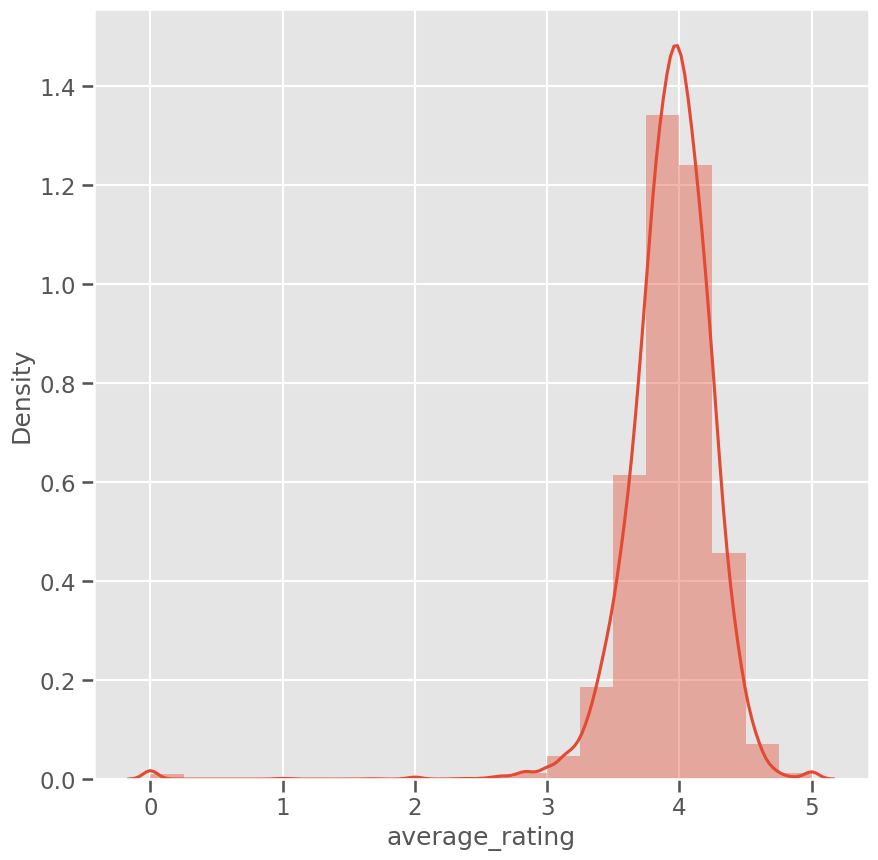

In [21]:
# plotting rating distribution for the books
plt.figure(figsize=(10,10))
rating= df.average_rating.astype(float)
sns.distplot(rating, bins=20)

In [22]:
def segregation(data):
    values = []
    for val in data.average_rating:
        if val>=0 and val<=1:
            values.append("Between 0 and 1")
        elif val>1 and val<=2:
            values.append("Between 1 and 2")
        elif val>2 and val<=3:
            values.append("Between 2 and 3")
        elif val>3 and val<=4:
            values.append("Between 3 and 4")
        elif val>4 and val<=5:
            values.append("Between 4 and 5")
        else:
            values.append("NaN")
    print(len(values))
    return values

11127


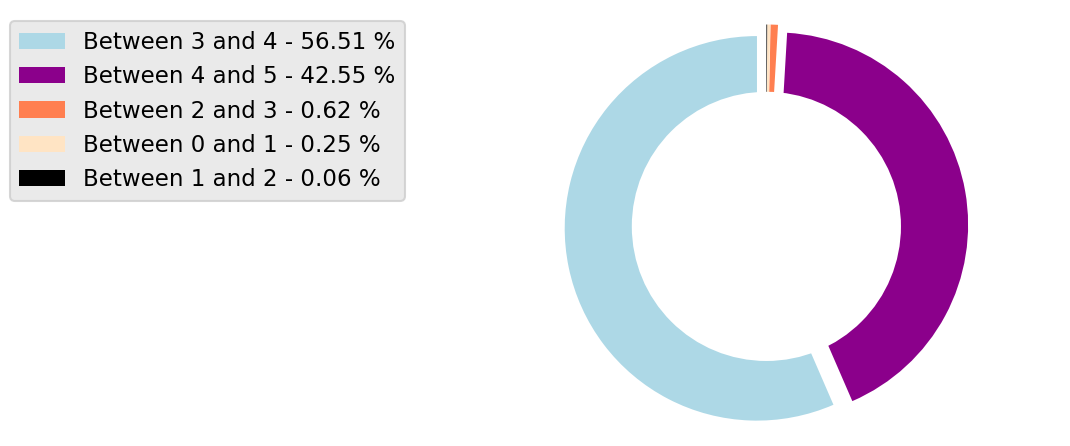

In [23]:
df['Ratings_Dist'] = segregation(df)
ratings_pie = df['Ratings_Dist'].value_counts().reset_index()
labels = ratings_pie['index']
colors = ['lightblue','darkmagenta','coral','bisque', 'black']
percent = 100.*ratings_pie['Ratings_Dist']/ratings_pie['Ratings_Dist'].sum()
fig, ax1 = plt.subplots()
ax1.pie(ratings_pie['Ratings_Dist'],colors = colors, 
        pctdistance=0.85, startangle=90, explode=(0.05, 0.05, 0.05, 0.05, 0.05))
#Draw a circle now:
centre_circle = plt.Circle((0,0), 0.70, fc ='white')
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)
#Equal Aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
plt.tight_layout()
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, percent)]
plt.legend( labels, loc = 'best',bbox_to_anchor=(-0.1, 1.),)

<Figure size 1500x1000 with 0 Axes>

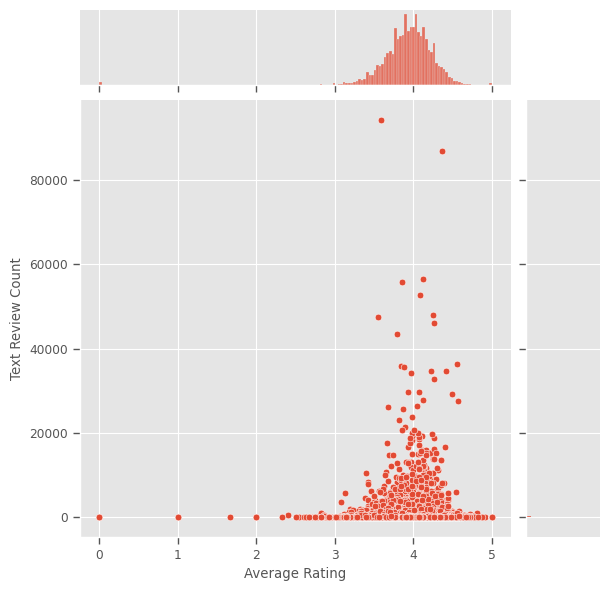

In [24]:
#Checking for any relation between them.
plt.figure(figsize=(15,10))
df.dropna(0, inplace=True)
sns.set_context('paper')
ax =sns.jointplot(x="average_rating",y='text_reviews_count', kind='scatter',  data= df[['text_reviews_count', 'average_rating']])
ax.set_axis_labels("Average Rating", "Text Review Count")
plt.show()

In [25]:
trial = df[~(df['text_reviews_count']>5000)]

<Figure size 1500x1000 with 0 Axes>

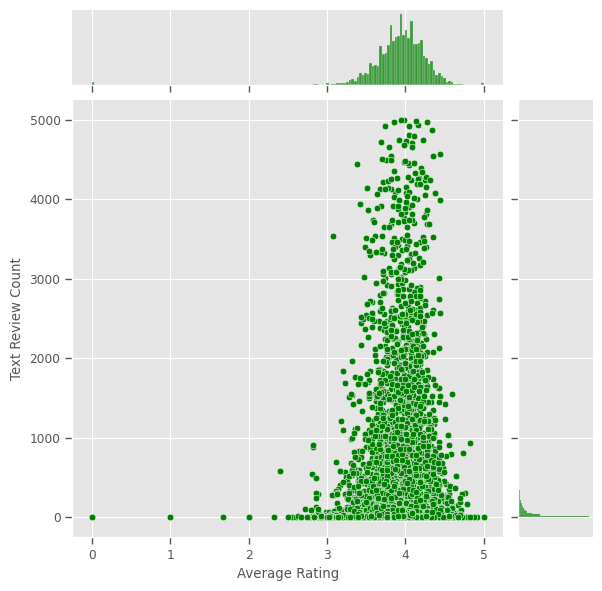

In [26]:
#Checking for any relation between ratings and review counts
plt.figure(figsize=(15,10))
df.dropna(0, inplace=True)
sns.set_context('paper')
ax =sns.jointplot(x="average_rating",y='text_reviews_count', kind='scatter',  data= trial, color = 'green')
ax.set_axis_labels("Average Rating", "Text Review Count")
plt.show()

In [27]:
df.columns

Index(['title', 'authors', 'average_rating', 'isbn', 'isbn13', 'language_code',
       '  num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher', 'Ratings_Dist'],
      dtype='object')

<Figure size 1500x1000 with 0 Axes>

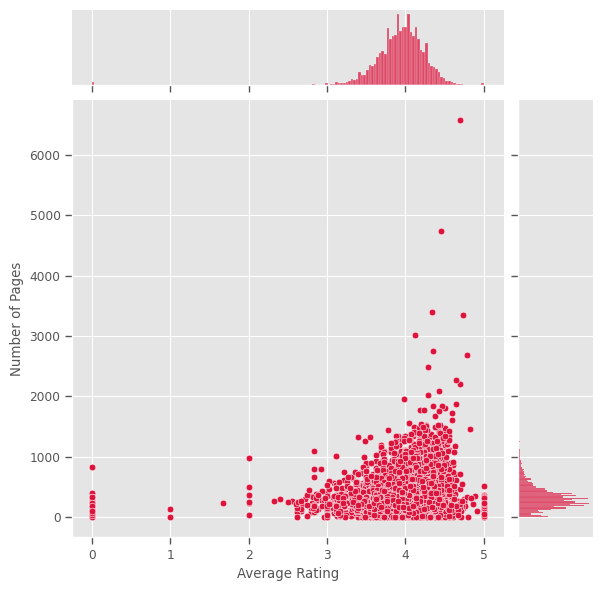

In [28]:
# Checking relation between number of pages and ratings
plt.figure(figsize=(15,10))
sns.set_context('paper')
ax = sns.jointplot(x="average_rating", y='  num_pages', data =df, color = 'crimson')
ax.set_axis_labels("Average Rating", "Number of Pages")

In [29]:
trial = df[~(df['  num_pages']>1000)]

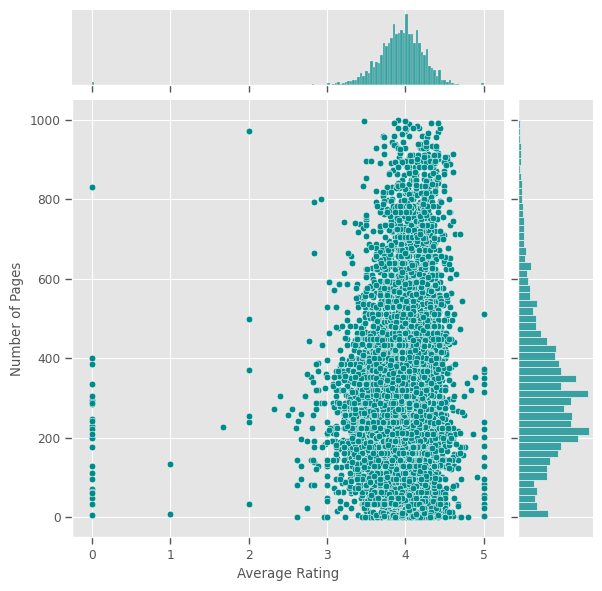

In [30]:
ax = sns.jointplot(x="average_rating", y="  num_pages", data = trial, color = 'darkcyan')
ax.set_axis_labels("Average Rating", "Number of Pages")

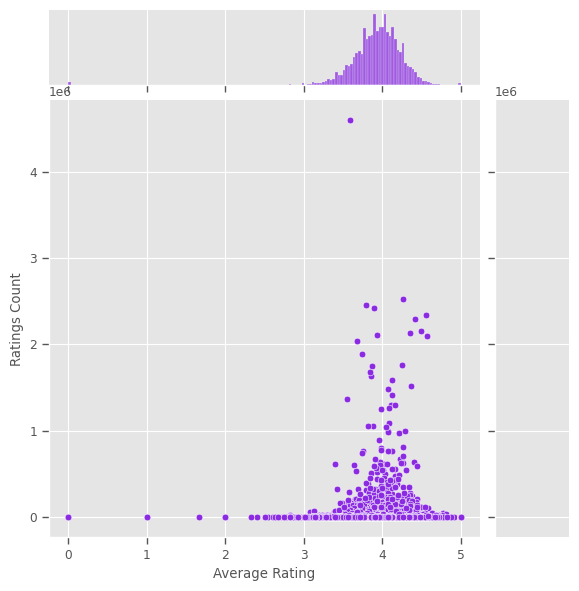

In [31]:
sns.set_context('paper')
ax = sns.jointplot(x="average_rating", y="ratings_count", data = df, color = 'blueviolet')
ax.set_axis_labels("Average Rating", "Ratings Count")

In [32]:
trial = df[~(df.ratings_count>2000000)]

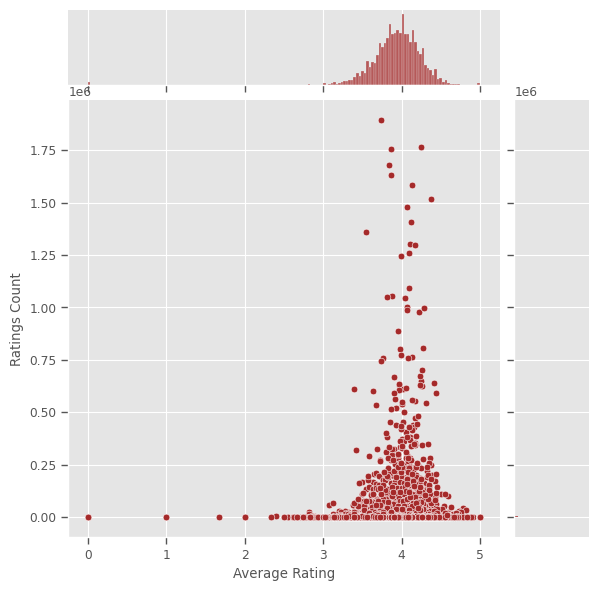

In [33]:
sns.set_context('paper')
ax = sns.jointplot(x="average_rating", y="ratings_count", data = trial, color = 'brown')
ax.set_axis_labels("Average Rating", "Ratings Count")

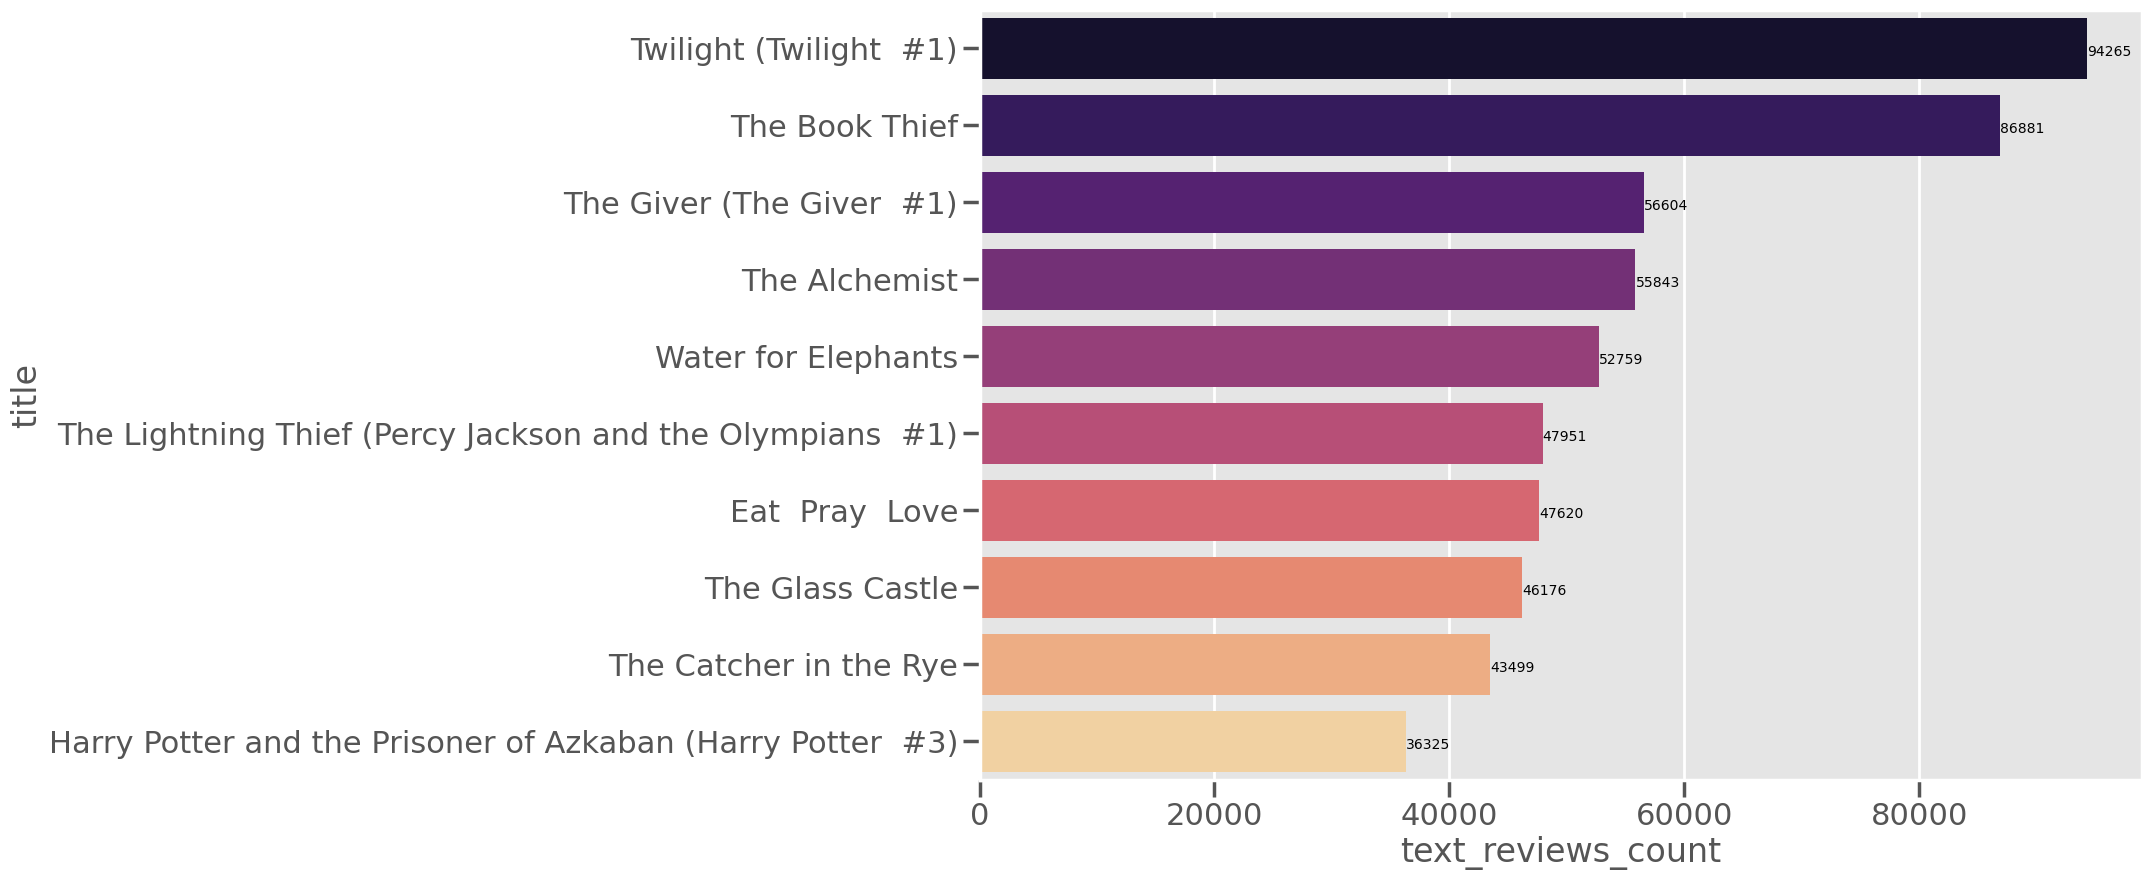

In [34]:
most_text = df.sort_values('text_reviews_count', ascending = False).head(10).set_index('title')
plt.figure(figsize=(15,10))
sns.set_context('poster')
ax = sns.barplot(most_text['text_reviews_count'], most_text.index, palette='magma')
for i in ax.patches:
    ax.text(i.get_width()+2, i.get_y()+0.5,str(round(i.get_width())), fontsize=10,color='black')
plt.show()

In [35]:
trial = df[['average_rating', 'ratings_count']]
data = np.asarray([np.asarray(trial['average_rating']), np.asarray(trial['ratings_count'])]).T

Text(0.5, 1.0, 'Elbow Curve')

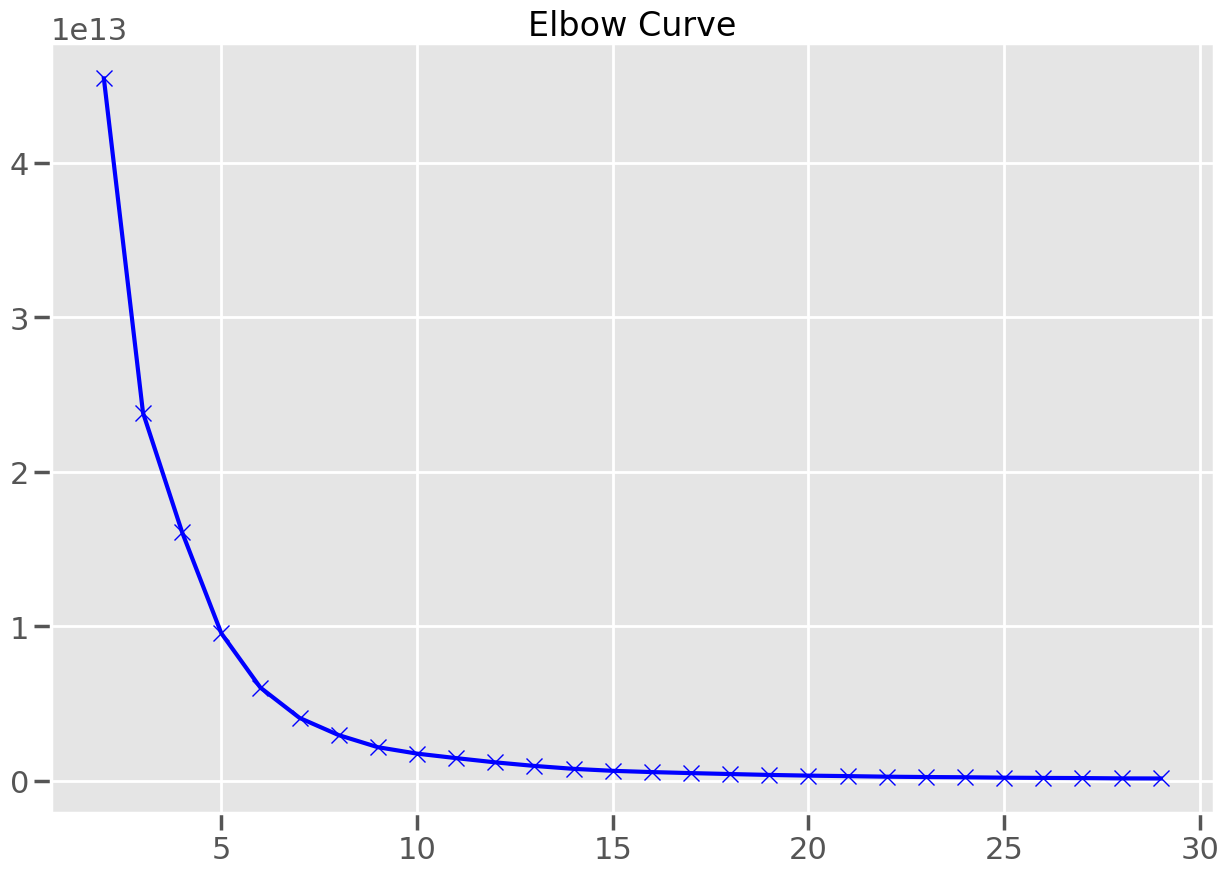

In [36]:
X = data
distortions = []
for k in range(2,30):
    k_means = KMeans(n_clusters = k)
    k_means.fit(X)
    distortions.append(k_means.inertia_)

fig = plt.figure(figsize=(15,10))
plt.plot(range(2,30), distortions, 'bx-')
plt.title("Elbow Curve")

In [37]:
#Computing K means with K = 5, thus, taking it as 5 clusters
centroids, _ = kmeans(data, 5)

#assigning each sample to a cluster
#Vector Quantisation:

idx, _ = vq(data, centroids)

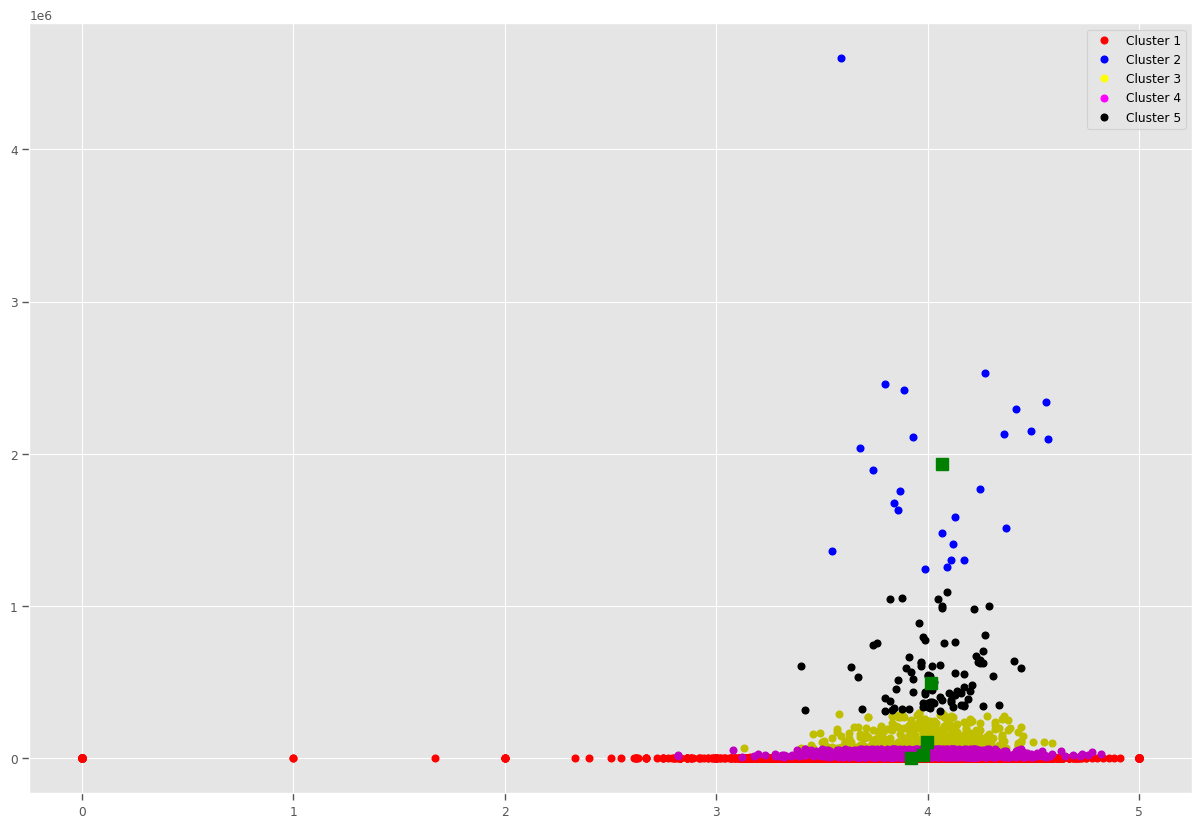

In [38]:
# some plotting using numpy's logical indexing
sns.set_context('paper')
plt.figure(figsize=(15,10))
plt.plot(data[idx==0,0],data[idx==0,1],'or',#red circles
     data[idx==1,0],data[idx==1,1],'ob',#blue circles
     data[idx==2,0],data[idx==2,1],'oy', #yellow circles
     data[idx==3,0],data[idx==3,1],'om', #magenta circles
     data[idx==4,0],data[idx==4,1],'ok',#black circles
    )
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=8, )


circle1 = Line2D(range(1), range(1), color = 'red', linewidth = 0, marker= 'o', markerfacecolor='red')
circle2 = Line2D(range(1), range(1), color = 'blue', linewidth = 0,marker= 'o', markerfacecolor='blue')
circle3 = Line2D(range(1), range(1), color = 'yellow',linewidth=0,  marker= 'o', markerfacecolor='yellow')
circle4 = Line2D(range(1), range(1), color = 'magenta', linewidth=0,marker= 'o', markerfacecolor='magenta')
circle5 = Line2D(range(1), range(1), color = 'black', linewidth = 0,marker= 'o', markerfacecolor='black')

plt.legend((circle1, circle2, circle3, circle4, circle5)
           , ('Cluster 1','Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'), numpoints = 1, loc = 0, )


plt.show()

In [39]:
trial.shape

(11127, 2)

In [40]:
trial.idxmax()

average_rating     2034
ratings_count     41865
dtype: int64

In [41]:
trial.loc[2034,:]

average_rating    5.0
ratings_count     0.0
Name: 2034, dtype: float64

In [42]:
trial.drop(2034, inplace = True)
trial.drop(41865, inplace = True)

In [43]:
data = np.asarray([np.asarray(trial['average_rating']), np.asarray(trial['ratings_count'])]).T

In [44]:
#Computing K means with K = 8, thus, taking it as 8 clusters
centroids, _ = kmeans(data, 5)

#assigning each sample to a cluster
#Vector Quantisation:

idx, _ = vq(data, centroids)

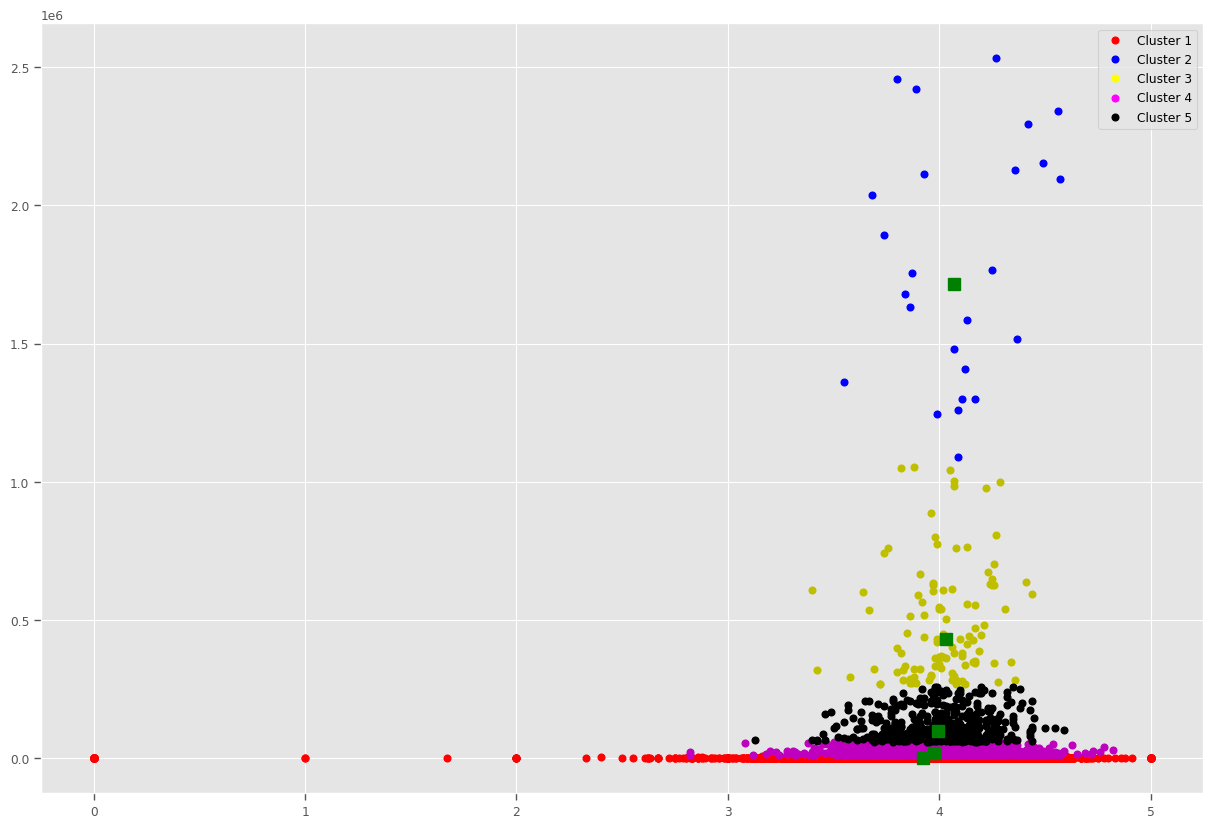

In [45]:
# some plotting using numpy's logical indexing
sns.set_context('paper')
plt.figure(figsize=(15,10))
plt.plot(data[idx==0,0],data[idx==0,1],'or',#red circles
     data[idx==1,0],data[idx==1,1],'ob',#blue circles
     data[idx==2,0],data[idx==2,1],'oy', #yellow circles
     data[idx==3,0],data[idx==3,1],'om', #magenta circles
     data[idx==4,0],data[idx==4,1],'ok',#black circles       
        )
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=8, )




circle1 = Line2D(range(1), range(1), color = 'red', linewidth = 0, marker= 'o', markerfacecolor='red')
circle2 = Line2D(range(1), range(1), color = 'blue', linewidth = 0,marker= 'o', markerfacecolor='blue')
circle3 = Line2D(range(1), range(1), color = 'yellow',linewidth=0,  marker= 'o', markerfacecolor='yellow')
circle4 = Line2D(range(1), range(1), color = 'magenta', linewidth=0,marker= 'o', markerfacecolor='magenta')
circle5 = Line2D(range(1), range(1), color = 'black', linewidth = 0,marker= 'o', markerfacecolor='black')

plt.legend((circle1, circle2, circle3, circle4, circle5)
           , ('Cluster 1','Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'), numpoints = 1, loc = 0, )


plt.show()

In [46]:
books_features = pd.concat([df['Ratings_Dist'].str.get_dummies(sep=","), df['average_rating'], df['ratings_count']], axis=1)

In [47]:
books_features.head()

,Between 0 and 1,Between 1 and 2,Between 2 and 3,Between 3 and 4,Between 4 and 5,average_rating,ratings_count
bookID,,,,,,,
1,0,0,0,0,1,4.57,2095690
2,0,0,0,0,1,4.49,2153167
4,0,0,0,0,1,4.42,6333
5,0,0,0,0,1,4.56,2339585
8,0,0,0,0,1,4.78,41428


In [48]:
lang_df = df['language_code'].str.get_dummies(sep=",")
lang_df.head()

,ale,ara,en-CA,en-GB,en-US,eng,enm,fre,ger,gla,...,nl,nor,por,rus,spa,srp,swe,tur,wel,zho
bookID,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
books_features = pd.concat([books_features, lang_df],axis=1)
books_features.head()

,Between 0 and 1,Between 1 and 2,Between 2 and 3,Between 3 and 4,Between 4 and 5,average_rating,ratings_count,ale,ara,en-CA,...,nl,nor,por,rus,spa,srp,swe,tur,wel,zho
bookID,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,1,4.57,2095690,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,4.49,2153167,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,4.42,6333,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,4.56,2339585,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,1,4.78,41428,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
books_features.shape

(11127, 34)

In [50]:
min_max_scaler = MinMaxScaler()
books_features = min_max_scaler.fit_transform(books_features)

In [51]:
np.round(books_features, 2)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [52]:
model = neighbors.NearestNeighbors(n_neighbors=6, algorithm='ball_tree')
model.fit(books_features)
distance, indices = model.kneighbors(books_features)

In [53]:
distance[1]

array([0.        , 0.02030477, 0.02652843, 0.0336718 , 0.04289518,
       0.09319683])

In [64]:
indices[6379]

array([6379, 1410, 5006, 4879,  543, 2314], dtype=int64)

In [67]:
df.head()

,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,Ratings_Dist
bookID,,,,,,,,,,,,
1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,439785960,9.780000e+12,eng,652,2095690,27591,9/16/2006,Scholastic Inc.,Between 4 and 5
2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,439358078,9.780000e+12,eng,870,2153167,29221,09-01-2004,Scholastic Inc.,Between 4 and 5
4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,439554896,9.780000e+12,eng,352,6333,244,11-01-2003,Scholastic,Between 4 and 5
5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9.780000e+12,eng,435,2339585,36325,05-01-2004,Scholastic Inc.,Between 4 and 5
8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,439682584,9.780000e+12,eng,2690,41428,164,9/13/2004,Scholastic,Between 4 and 5


In [103]:
df.reset_index(inplace=True)

In [104]:
df[df["title"]=="The Thirteenth Tribe"].index.tolist()[0]

8008

In [105]:
def get_index_from_name(name):
    return df[df["title"]==name].index.tolist()[0]

all_books_names = list(df.title.values)

def get_id_from_partial_name(partial):
    for name in all_books_names:
        if partial in name:
            print(name,all_books_names.index(name))
            
def print_similar_books(query=None,id=None):
    if id:
        for id in indices[id][1:]:
            print(df.iloc[id]["title"])
    if query:
        found_id = get_index_from_name(query)
        for id in indices[found_id][1:]:
            print(df.iloc[id]["title"])

In [106]:
print_similar_books("Warrior of the Light")

The Cat Who Walks Through Walls (The World As Myth)
All Through the Night
Question Quest (Xanth #14)
Tolkien and the Great War: The Threshold of Middle-earth
The Wanting Seed


In [111]:
print_similar_books("Imaginary Friends")

The Fashion System
Dragon's Treasure
Kevin Trudeau's Mega Memory: How to Release Your Superpower Memory in 30 Minutes Or Less a Day
The Good Liar
Exile's Children (Exiles  #1)


In [108]:
get_id_from_partial_name("Harry Potter and the ")

Harry Potter and the Half-Blood Prince (Harry Potter  #6) 0
Harry Potter and the Order of the Phoenix (Harry Potter  #5) 1
Harry Potter and the Chamber of Secrets (Harry Potter  #2) 2
Harry Potter and the Prisoner of Azkaban (Harry Potter  #3) 3
Harry Potter and the Half-Blood Prince (Harry Potter  #6) 0
Harry Potter and the Prisoner of Azkaban (Harry Potter  #3) 3
Harry Potter and the Chamber of Secrets (Harry Potter  #2) 2
Harry Potter and the Sorcerer's Stone (Harry Potter  #1) 8876
Harry Potter and the Philosopher's Stone (Harry Potter  #1) 10678
Harry Potter and the Goblet of Fire (Harry Potter  #4) 10679


In [110]:
print_similar_books(id = 876) #ID for the Book 5

The Spider's House
Siddhartha
On Being Ill
'Salem's Lot
Revolutionary Girl Utena  Vol. 5: To Blossom
